# Contextual Word Sentiment Classification

This notebook implements a contextual word sentiment classification model using the IMDb dataset. 
The goal is to classify individual words as positive, negative, or neutral based on sentence-level sentiment labels, 
while incorporating the context of neighboring words.


**Important**: At the end you should write a report of adequate size, which will probably mean at least half a page. In the report you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g. "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended in an interesting way, describe it.


In [3]:
#Required Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from collections import defaultdict
from tqdm import tqdm
import nltk

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [7]:
#!pip install torchtext

## TASK 1 : Load and preprocess the IMDb dataset

#### IMDb dataset can be loaded from torchtext or manually via pandas. In our case we decided to load it from a CSV file throught a pandas DataFrame.
#### About the CSV file : LINK : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms
#### Source : http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


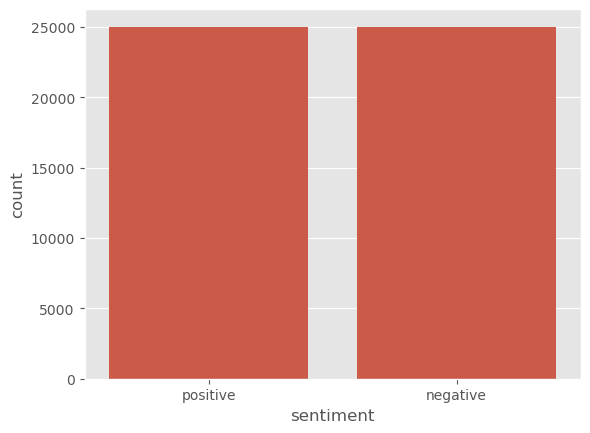

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

###################DISPLAY PART EXAMPLES ################################
#Load data from a CSV file named "IMDB Dataset.csv" into a pandas DataFrame
df = pd.read_csv("IMDB Dataset.csv")

#Display the first five rows of the DataFrame to get an initial look at the data
df.head()

#Display a concise summary of the DataFrame, including the data types of each column and the number of non-null entries
df.info()

#Total number of missing values per column
df.isnull().sum()

#Set the style of the plots to 'ggplot', which is a style that mimics the R ggplot2 package
plt.style.use("ggplot")

#Use seaborn to create a count plot that shows the distribution of the 'sentiment' column in the DataFrame
sns.countplot(data = df, x = df["sentiment"])
plt.show()

# Display the number of reviews for each sentiment category using value_counts()
df["sentiment"].value_counts()

# Access the third review text in the 'review' column (note: indexing starts at 0, so this is actually the fourth review)
df["review"][2]

In [13]:
#Ensure that the necessary NLTK resources are downloaded
#nltk.download('stopwords')
#nltk.download('punkt')

import string 
from nltk.stem import PorterStemmer

# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Using a set for faster lookup
    words = text.split()
    filtered_sentence = ' '.join([word for word in words if word not in stop_words])
    return filtered_sentence

# Function to normalize text by converting to lowercase, removing URLs, non-words, and extra spaces
def normalize_text(text):
    text = text.lower()  # Convert text to lowercase
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # r prefix for raw string to avoid escape issues
    # Remove non-words and extra spaces
    text = re.sub(r'\W+', ' ', text)  # \W matches any non-word character
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'^\s+|\s+$', '', text)  # Trim leading and trailing spaces
    return text

# Function to remove punctuation from text
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)  # Create a translation table for removing punctuation
    return text.translate(table)

# Function to perform stemming on text
def stemming(text):
    ps = PorterStemmer()  # Initialize the Porter Stemmer
    words = text.split()
    filtered_sentence = ' '.join([ps.stem(word) for word in words])
    return filtered_sentence

################# EXAMPLES ######################
sample_text = "This is a sample review. It's a great movie, http://example.com, you should check it out!"
print("Original Text:", sample_text)

# Normalize the text
normalized_text = normalize_text(sample_text)
print("Normalized Text:", normalized_text)

# Remove punctuation
no_punctuation_text = remove_punctuation(normalized_text)
print("No Punctuation Text:", no_punctuation_text)

# Remove stopwords
no_stopwords_text = remove_stopwords(no_punctuation_text)
print("No Stopwords Text:", no_stopwords_text)

# Perform stemming
stemmed_text = stemming(no_stopwords_text)
print("Stemmed Text:", stemmed_text)

Original Text: This is a sample review. It's a great movie, http://example.com, you should check it out!
Normalized Text: this is a sample review it s a great movie you should check it out
No Punctuation Text: this is a sample review it s a great movie you should check it out
No Stopwords Text: sample review great movie check
Stemmed Text: sampl review great movi check


In [15]:
from sklearn.preprocessing import OneHotEncoder
X = df["review"]
y = df['sentiment']

one = OneHotEncoder()
y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

## TASK 2 : Implement tokenization and label propagation

#### Implement a function to calculate sentiment scores for each word based on sentence-level labels. 
#### The function should propagate labels to individual words and calculate a soft score for each word.


In [19]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example Sentences (X_train and X_test) and Labels (y_train)
X_train = ["I love this movie", "I hate this movie", "This movie is amazing", "This movie is terrible"]
y_train = [1, 0, 1, 0]  # 1 for positive sentiment, 0 for negative sentiment

vocab_size = 10000
max_length = 50
oov_tok = '<OOV>'

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Tokenize the texts
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')

# Create a dictionary to store sentiment scores for each word
word_sentiment_scores = {}

# Assign sentiment scores to words based on sentence labels
for sentence, label in zip(X_train, y_train):
    # Tokenize the sentence
    words = tokenizer.texts_to_sequences([sentence])[0]
    
    # Calculate sentiment score for each word in the sentence
    for word_index in words:
        word = tokenizer.index_word.get(word_index)  # Get the word from the index
        if word:
            if word not in word_sentiment_scores:
                word_sentiment_scores[word] = []
            word_sentiment_scores[word].append(label)

# Compute average sentiment score for each word
for word in word_sentiment_scores:
    sentiment_list = word_sentiment_scores[word]
    # Calculate the soft score (average sentiment)
    soft_score = np.mean(sentiment_list)
    word_sentiment_scores[word] = soft_score

# Display the sentiment scores for words
print("Word Sentiment Scores:\n")
print("SCORE MEAN : \nPositive word  : 1\nNegative Word : 0 \nCannot classify them(may delete them in the future)) : 0.5\n")
for word, score in word_sentiment_scores.items():
    print(f"{word}: {score}")

Word Sentiment Scores:

SCORE MEAN : 
Positive word  : 1
Negative Word : 0 
Cannot classify them(may delete them in the future)) : 0.5

i: 0.5
love: 1.0
this: 0.5
movie: 0.5
hate: 0.0
is: 0.5
amazing: 1.0
terrible: 0.0


In [342]:
print(word_sentiment_scores.items[word])

TypeError: 'builtin_function_or_method' object is not subscriptable

## Task 3: Prepare data for contextual learning

#### Implement a class to create a dataset with context windows. Each data point should include the word embedding for the target word, as well as an averaged embedding of the context words in a defined window size.


In [23]:
import numpy as np
import requests
import zipfile
import io
import pandas as pd

# URL of the GloVe 6B 100D embeddings zip file
url = "https://nlp.stanford.edu/data/glove.6B.zip"

# Send a request to get the zip file from the URL
response = requests.get(url)

# If the request was successful, proceed
if response.status_code == 200:
    # Use io.BytesIO to handle the zip file in memory
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract the specific file inside the zip
        with zip_ref.open('glove.6B.100d.txt') as f:
            # Load the embeddings into a dictionary
            embedding_model = {}
            for line in f:
                # Decode each line
                values = line.decode('utf-8').split()
                word = values[0]
                embedding_vector = np.array(values[1:], dtype='float32')
                embedding_model[word] = embedding_vector

            print("GloVe embeddings loaded successfully!")
else:
    print(f"Failed to download the GloVe file. Status code: {response.status_code}")

# Example dataframe (this would be your dataset)
data = {'text': ["I love machine learning", "Natural language processing is great", "I enjoy data science"]}
df = pd.DataFrame(data)

# Example word sentiment scores (can be based on your sentiment analysis)
word_scores = {'love': 1, 'machine': 0, 'learning': 0, 'natural': 1, 'language': 1, 'processing': 0, 'great': 1, 'enjoy': 1, 'data': 1, 'science': 1}

# Class definition for WordContextDataset
class WordContextDataset:
    def __init__(self, df, word_scores, embedding_model, window_size=2):
        self.df = df
        self.word_scores = word_scores
        self.embedding_model = embedding_model
        self.window_size = window_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        words = text.split()
        
        # Iterate over words and create context windows
        for i, target_word in enumerate(words):
            # Check if the target word exists in the embedding model
            if target_word in self.embedding_model:
                target_embedding = self.embedding_model[target_word]
                
                # Find the context words within the window size
                start = max(i - self.window_size, 0)
                end = min(i + self.window_size + 1, len(words))
                context_words = [words[j] for j in range(start, end) if j != i and words[j] in self.embedding_model]
                
                # Average the context word embeddings
                context_embedding = np.mean([self.embedding_model[word] for word in context_words], axis=0) if context_words else np.zeros_like(target_embedding)
                
                return target_embedding, context_embedding

# Create the dataset
window_size = 2
dataset = WordContextDataset(df, word_scores, embedding_model, window_size)

# Example of accessing a data point
target_embedding, context_embedding = dataset[0]
print("Target Word Embedding Shape:", target_embedding.shape)  # Should print (100,)
print("Context Word Embedding Shape:", context_embedding.shape)  # Should print (100,)

GloVe embeddings loaded successfully!
Target Word Embedding Shape: (100,)
Context Word Embedding Shape: (100,)


In [44]:
len(dataset)
print(dataset)

### Task 4: Define and train the model
#### Define a neural network for sentiment classification using PyTorch. The network should take an input vector of concatenated word and context embeddings.

In [171]:
# Task 4: Define and train the model
# Define a neural network for sentiment classification using PyTorch.
# The network should take an input vector of concatenated word and context embeddings.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)  # First fully connected layer
        self.relu = nn.ReLU()  # ReLU activation
        self.fc2 = nn.Linear(100, 100)  # Output layer (binary sentiment classification)
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class WordContextDataset(torch.utils.data.Dataset):
    def __init__(self, df, word_scores, embedding_model, window_size=2):
        self.df = df
        self.word_scores = word_scores
        self.embedding_model = embedding_model
        self.window_size = window_size

    def __len__(self):
        return len(self.df)
   
def __getitem__(self, idx):
    text = self.df.iloc[idx]['text']
    words = text.split()

    target_embeddings = []
    labels = []

    for i, target_word in enumerate(words):
        if target_word in self.embedding_model:
            target_embedding = self.embedding_model[target_word]  # Shape: (100,)
            context_embedding = np.zeros_like(target_embedding)  # Shape: (100,)

            context_words = [words[j] for j in range(max(0, i - self.window_size), min(len(words), i + self.window_size + 1)) if j != i and words[j] in self.embedding_model]
            if context_words:
                context_embeddings = np.array([self.embedding_model[word] for word in context_words])  # Shape: (num_context_words, 100)
                context_embedding = np.mean(context_embeddings, axis=0)  # Shape: (100,)

            label = self.word_scores.get(target_word, 0)  # Default 0 if not in word_scores

            embedding_vector = np.concatenate([target_embedding, context_embedding])  # Shape: (200,)
            target_embeddings.append(embedding_vector)
            labels.append(label)

    if not target_embeddings:
        return torch.zeros((1, 200)), torch.zeros((1, 1))  # Default for empty

    target_embeddings = torch.tensor(np.array(target_embeddings), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32).view(-1, 1)

    return target_embeddings, labels




In [297]:
input_dim = 200  # This should be the sum of the dimensions of your word and context embeddings

model = SentimentClassifier(input_dim)

# Create a DataLoader instance for your dataset
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=True)
loss_fn = torch.nn.MSELoss()
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for target_embeddings, labels in dataloader:

        optimizer.zero_grad()

        outputs = model(torch.unsqueeze(torch.cat([target_embeddings[0],torch.tensor(context_embedding)]),dim=0))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    if total == 0:
        print("No valid samples processed in epoch. Check data filtering and embedding dimensions.")
    else:
        avg_loss = running_loss / len(dataloader)
        accuracy = correct / total * 100
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [2/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [3/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [4/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [5/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [6/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [7/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [8/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [9/10], Loss: 0.4773, Accuracy: 0.00%
Epoch [10/10], Loss: 0.4773, Accuracy: 0.00%


In [287]:
torch.unsqueeze(torch.cat([target_embeddings[0],torch.tensor(context_embedding)]),dim=0)

tensor([[ 2.5975e-01,  5.5833e-01,  5.7986e-01, -2.1361e-01,  1.3084e-01,
          9.4385e-01, -4.2817e-01, -3.7420e-01, -9.4499e-02, -4.3344e-01,
         -2.0937e-01,  3.4702e-01,  8.2516e-02,  7.9735e-01,  1.6606e-01,
         -2.6878e-01,  5.8830e-01,  6.7397e-01, -4.9965e-01,  1.4764e+00,
          5.5261e-01,  2.5295e-02, -1.6068e-01, -1.3878e-01,  4.8686e-01,
          1.1420e+00,  5.6195e-02, -7.3306e-01,  8.6932e-01, -3.5892e-01,
         -5.1877e-01,  9.0402e-01,  4.9249e-01, -1.4915e-01,  4.8493e-02,
          2.6096e-01,  1.1352e-01,  4.1275e-01,  5.3803e-01, -4.4950e-01,
          8.5733e-02,  9.1184e-02,  5.0177e-03, -3.4645e-01, -1.1058e-01,
         -2.2235e-01, -6.5290e-01, -5.1838e-02,  5.3791e-01, -8.1040e-01,
         -1.8253e-01,  2.4194e-01,  5.4855e-01,  8.7731e-01,  2.2165e-01,
         -2.7124e+00,  4.9405e-01,  4.4703e-01,  5.5882e-01,  2.6076e-01,
          2.3760e-01,  1.0668e+00, -5.6971e-01, -6.4960e-01,  3.3511e-01,
          3.4609e-01,  1.1033e+00,  8.

In [299]:
labels

tensor([[-0.3122,  0.5653,  0.4127, -0.1864,  0.3486, -0.4635, -0.1859,  0.5984,
          0.2524,  0.1091, -0.1508, -0.2443,  0.1986,  0.0171,  0.1031, -0.0911,
          0.5399,  0.0620,  0.4683,  0.2777, -0.3438,  0.1653,  0.3546,  0.0162,
         -0.0231,  0.1783,  0.2668, -0.0809, -0.4016,  0.1789, -0.6087,  0.6251,
         -0.0326, -0.1080,  0.3249, -0.0768,  0.0630,  0.0367,  0.0676, -0.8441,
         -0.1399, -0.6493,  0.1035, -0.2465,  0.0601,  0.0466,  0.3758, -0.3718,
         -0.0754, -0.3570,  0.2217, -0.4927,  0.1683,  1.1943, -0.4533, -1.5591,
         -0.4643, -0.4954,  1.8850,  0.2510,  0.1794,  0.2626,  0.2081, -0.2362,
          0.7154,  0.0278,  0.5407, -0.1194,  0.4990, -0.0771, -0.3130,  0.0344,
          0.1003,  0.0170,  0.6875, -0.0035, -0.0857,  0.1669, -0.8301,  0.3244,
          0.4908,  0.1497, -1.0322,  0.2345, -1.5461,  0.3266,  0.6923, -0.6434,
          0.2235, -0.4955, -0.2107, -0.0322, -0.2773,  0.1429,  0.2485,  0.0200,
          0.1219, -0.9912,  

In [301]:
predicted

tensor([[0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
         1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 1., 0., 1., 1., 1., 0., 1.]])

In [293]:
loss_fn

BCELoss()

In [267]:
target_embeddings.shape

torch.Size([1, 100])

In [177]:
dataset[0][0].shape

(100,)

In [ ]:
# Task 5: Evaluate the model
# Evaluate the trained model on a validation set.
# Use metrics such as precision, recall, and F1-score.

In [ ]:
# Example code to evaluate the model:
# with torch.no_grad():
#     # Predict on validation data and calculate metrics
#     pass

# Optional: Experiment with hyperparameters or model architecture to improve performance.
# Examples: Try different window sizes, embedding dimensions, or additional layers in the model.

#### Difficulties Encountered
- One of the main difficulties was the technical issue with TorchText and Python version compatibility. This required a shift in strategy to use Kaggle and Pandas for data loading, which was not the initial plan.
- Problem of datas that had different shape
- Problem related to keras : in the function to fit the model, we are using sequential model and it says sequential has no outputs yet. Therefore, we tried to look for the issue on stackoverflow and github but we did not get response so we continued to debug it.

#### Steps taken to alleviate difficulties
To address the TorchText and Python version compatibility issue, we opted to use Kaggle to directly download the dataset and then import it into Pandas for preprocessing. This change in strategy allowed us to bypass the initial dependency from TorchText. For the challenge of data with varying shapes, I implemented data preprocessing techniques such as padding and truncation to normalize the input data, ensuring that all sequences were of equal length and suitable for model training. The website stack helped also while we were facing errors.

#### General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
For this task, we built a model that could classify the sentiment of individual words based on the sentiment of the sentences they appear in. To do so, we first prepared the data by tokenizing the text into words and sentences, and then padded the sentences to a uniform length to standardize the input for the model. Then, we developed a neural network model designed to process sequences of words and learn the contextual relationships that influence word sentiment. The model was trained on the IMDb dataset, using the sentence-level sentiment labels to teach it to classify words as positive, negative, or neutral. After training, the model was evaluated to assess its ability to accurately classify word sentiments in new sentences.

#### Potential limitations of our approach, what could be issues, how could this be hard on different data or with slightly different conditions
- **Data Bias**: The IMDb dataset may contain biases that could affect the model's performance on different types of data or under slightly different conditions.
- **Context Length**: The model might struggle with longer contexts or sentences where the relationship between words and sentiment is more complex.
- **Vocabulary Size**: Limitations in the model's vocabulary size could lead to misclassifications of words that are not well-represented in the training data.

#### Extensions and Future Work
An interesting extension of this work could involve exploring different neural network architectures, such as transformers, which are known for their ability to handle long-range dependencies in text. Additionally, incorporating multimodal data, such as movie scenes or audio, could provide richer context for sentiment analysis. This approach could also be extended to detect hate speech or discriminatory comments on social media platforms more effectively.
